In [41]:
import pandas as pd
import numpy as np
from numpy import array
import matplotlib.pyplot as plt
%matplotlib inline
import os
import warnings
warnings.filterwarnings("ignore")

In [64]:
path_data = 'data/'
path_models = 'models/'
file_X = 'dataframe_1.csv'
file_Y = 'dataframe_Y.csv'
#os.chdir(path_data)
print(os.listdir())

['dataframe_Y.csv', 'dataframe_1.csv', 'Tseny_2010-20.xlsx', 'dataframe_pct_change.csv', 'spisok_factors_for_del.txt']


In [43]:
analyze_period = 10000    # Сколько баров в прошлое берем для тренировки модели
#valX = 100    # Сколько баров оставляем для проверки обучения

ensemble = 5
forvard_lag = 0
test_lvl = .2             # Обьем выборки, уходящей в xTest

## Загрузка данных

In [44]:
# Удаляем данные, не имеющие связи с ценой на пальмовое масло на Train периоде
data = pd.read_csv(file_X, sep=",", index_col=['date'])
data = data[-analyze_period:] # Убрали устаревшую информацию
correlations = np.abs(data.corrwith(data['Пальмовое масло   RBD, FOB Малайзия , usd/тн ']))
print(data.shape)
print(correlations.sort_values(ascending=True))
print('-'*90)

spisok_factors_for_del = []
lim = 0.87 # удалим те факторы, влияние которых слабее 0.8
for i in range(len(correlations)):
    if correlations[i] <= lim:
        print('Удален: ', correlations[i], ' \t', correlations.index[i])
        spisok_factors_for_del.append(correlations.index[i])
        del data[correlations.index[i]]

with open('spisok_factors_for_del.txt', 'w') as f: # запишем в файл те факторы, которые удалили
    f.write("\n".join(spisok_factors_for_del))

print('-'*90)
print(spisok_factors_for_del)
print(data.shape)
data[:3]

(2652, 10)
Coconut oil, Phil., cif Rot.                     0.519043
Palmkernel oil, Mal., cif Rot.                   0.674752
Sunoil, Arg., fob                                0.854962
Sunoil, Ukraine, fob                             0.857016
Rape oil, Dutch, fob ex-mill                     0.864449
Sunoil, EU, fob N.W.Eur. ports                   0.869170
Soybean oil, Argentina, fob                      0.875860
Soybean oil, Brazil, fob                         0.881398
Palm olein RBD, Mal., fob                        0.941436
Пальмовое масло   RBD, FOB Малайзия , usd/тн     1.000000
dtype: float64
------------------------------------------------------------------------------------------
Удален:  0.8691698585984332  	 Sunoil, EU, fob N.W.Eur. ports
Удален:  0.8549622602108576  	 Sunoil, Arg., fob
Удален:  0.8570159314353231  	 Sunoil, Ukraine, fob
Удален:  0.864448915712343  	 Rape oil, Dutch, fob ex-mill
Удален:  0.6747523922997528  	 Palmkernel oil, Mal., cif Rot.
Удален:  0.51904278

,"Soybean oil, Brazil, fob","Soybean oil, Argentina, fob","Palm olein RBD, Mal., fob","Пальмовое масло RBD, FOB Малайзия , usd/тн"
date,,,,
2010-01-04,896,891,822,775.0
2010-01-05,895,890,830,775.0
2010-01-06,891,887,830,797.5


In [45]:
del data['Пальмовое масло   RBD, FOB Малайзия , usd/тн ']
data[:3]

,"Soybean oil, Brazil, fob","Soybean oil, Argentina, fob","Palm olein RBD, Mal., fob"
date,,,
2010-01-04,896,891,822
2010-01-05,895,890,830
2010-01-06,891,887,830


In [46]:
# Загрузка Y
data_Y = pd.read_csv(file_Y, sep=",", index_col=['date'])
data_Y.rename(columns={'Пальмовое масло   RBD, FOB Малайзия , usd/тн ': 'Y'}, inplace=True)
data_Y = data_Y[-analyze_period:] # Убрали устаревшую информацию
print(data_Y.shape)
data_Y[-3:]

(2652, 1)


,Y
date,
2020-10-22,920.0
2020-10-23,917.5
2020-10-26,912.5


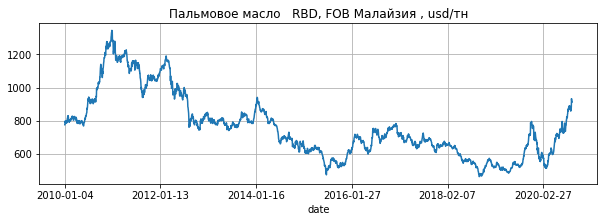

In [47]:
plt.figure(figsize=(10,4))
ax0 = plt.subplot2grid((4,4), (0, 0), rowspan=3, colspan=4)
data_Y['Y'].plot(ax = ax0)
plt.title('Пальмовое масло   RBD, FOB Малайзия , usd/тн')
plt.grid()

## Подготовка данных

### Делим на обучающую, тестовую и валидационную выборки

In [48]:
type(data), type(data_Y)

(pandas.core.frame.DataFrame, pandas.core.frame.DataFrame)

In [49]:
data = data.values
data_Y = data_Y.values
xTrain = data
yTrain = data_Y
type(data), type(data_Y)

(numpy.ndarray, numpy.ndarray)

In [50]:
# берем для xTest последние 20% значений, но кратно ensemble
n_train = int(len(data)*test_lvl// ensemble * ensemble) #  то, что уходит в train 
xTrain = data[:-n_train]
xTest = data[-n_train:]
yTrain = data_Y[:-n_train]
yTest = data_Y[-n_train:]

print('xTrain: ', xTrain.shape, '\tyTrain:', yTrain.shape,
      '\nxTest:  ', xTest.shape, '\tyTest: ', yTest.shape)
xTrain.shape[0]+xTest.shape[0]

xTrain:  (2122, 3) 	yTrain: (2122, 1) 
xTest:   (530, 3) 	yTest:  (530, 1)


2652

### Скалирование Х

In [51]:
from sklearn.preprocessing import StandardScaler, RobustScaler, MinMaxScaler # проверить все
""" 
# Масштабируем только X
"""
xScaler = StandardScaler()
#xScaler = RobustScaler()
#xScaler = MinMaxScaler()
xScaler.fit(xTrain)
xTrain = xScaler.transform(xTrain)
xTest = xScaler.transform(xTest)

print(xTrain.shape, xTest.shape, type(xTrain))
xTest[-1:]

(2122, 3) (530, 3) <class 'numpy.ndarray'>


array([[ 0.18667895, -0.19201303, -0.01632612]])

In [52]:
# проверяю обратную трансформацию
xScaler.inverse_transform(xTest[-1:])

array([[936., 857., 805.]])

### Превращение в TimeSeries

In [53]:
"""
#### Функция разделения массива на выборки для обучения нейросети 
"""
# sequence = строка массива df
# trend = число баров в прошлом для анализа - необходимо найти оптимальный!!
# forvard_lag = предсказание какого бара в будущем делаем 

def split_sequence(sequence, Y, ensemble, forvard_lag):
  # sequence = df.values - это массив из данных
  # trend = число баров в прошлом для анализа
  X, y = list(), list()
  for i in range(len(sequence)):
    end_ix = i + ensemble # находим конечный индекс строки
    if end_ix + (forvard_lag-1) > len(sequence)-1: # cпроверем чтобы не выйти за пределы массива
      break 
    # получаем X и y
    seq_x, seq_y = sequence[i:end_ix], Y[end_ix + (forvard_lag - 1)]
    X.append(seq_x)
    y.append(seq_y) # тк предсказываем только Close
  return array(X), array(y)

In [54]:
# Формируем выборки для обучения нейросети
xTrain, yTrain = split_sequence(xTrain, yTrain, ensemble, forvard_lag)
print('Массивы xTrain и yTrain:\t', xTrain.shape, yTrain.shape)

Массивы xTrain и yTrain:	 (2118, 5, 3) (2118, 1)


In [55]:
# Формируем выборки для обучения нейросети
xTest, yTest = split_sequence(xTest, yTest, ensemble, forvard_lag)
print('Массивы xTest и yTest:\t', xTest.shape, yTest.shape)

Массивы xTest и yTest:	 (526, 5, 3) (526, 1)


In [56]:
close = xScaler.inverse_transform(xTest[-1])
close[-1][0], yTest[-1]

(936.0, array([912.5]))

# Нейросети

### Загрузка библиотек и функция отрисовки графиков

In [57]:
from tensorflow.keras.models import Sequential, Model, load_model
from tensorflow.keras.layers import (concatenate, Input, Dense, Dropout, BatchNormalization, Flatten, 
                                     GRU, LSTM, Bidirectional, Conv1D, SeparableConv1D, MaxPooling1D,
                                     Reshape, RepeatVector, SpatialDropout1D, LeakyReLU)
from tensorflow.keras.optimizers import Adam, Nadam, RMSprop, Adamax
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau, ModelCheckpoint
from tensorflow.keras import utils
from keras.utils import plot_model
from IPython.display import clear_output

In [58]:
def plotting(history):
  clear_output()
  print('Min al_loss = ', min(history.history['val_loss']))
  plt.figure(figsize=(7,3))
  plt.plot(history.history['loss'], label='loss')
  plt.plot(history.history['val_loss'], label='val_loss')
  plt.legend()
  plt.grid()
  plt.show()

  plt.figure(figsize=(16,4))
  plt.subplot(1,2,1)
  plt.plot(model.predict(xTrain), label='yTrain_pred')
  plt.plot(yTrain, label='yTrain')
  plt.legend()
  plt.grid()

  plt.subplot(1,2,2)
  plt.plot(model.predict(xTest), label='yTest_pred')
  plt.plot(yTest, label='yTest')
  plt.legend()
  plt.grid()
  plt.show()

### Conv

In [59]:
# Гиперпараметры
drop = 0

In [60]:
input = Input(shape=(xTrain.shape[1], xTrain.shape[2]))
# xTrain.shape[1] - число шагов назад для обучения
# xTrain.shape[2] - число столбцов в обучающей выборке

x = Conv1D(200, 2, activation='relu')(input)
x = BatchNormalization()(x)
x = Flatten()(x)
x = Dense(ensemble*200, activation='relu')(x)
x = Dropout(drop)(x)
x = Dense(yTrain.shape[1], activation='linear')(x)

model = Model(input, x)

#print(model.summary()) #Вывод структуры модели
#plot_model(model, dpi=50, show_shapes=True, show_layer_names=True)

In [67]:
#xTrain , yTrain = X, y # если не используется TimeSeries
model.compile(optimizer=Adam(lr=1e-3), loss='mse')
#os.chdir(path_models)

# коллбэки
early_stopping = EarlyStopping(monitor = 'val_loss', patience = 12, verbose = 0, 
                               restore_best_weights = True)
reduce_lr = ReduceLROnPlateau(monitor = 'val_loss', factor=0.5, patience=1, min_lr=1e-07, verbose = 0)
checkpoint = ModelCheckpoint('models/model_Conv.h5', monitor='val_loss', verbose = 0,
                             save_best_only = True)

# fit model
history = model.fit(xTrain, yTrain, epochs=200, verbose = 1,
                    validation_data=(xTest, yTest),
                    #batch_size = 5,
                    callbacks = [early_stopping, reduce_lr, checkpoint])

plotting(history)

Epoch 1/200
67/67 [==============================] - 2s 12ms/step - loss: 6829.3902 - val_loss: 21202.8047


PermissionDeniedError: /models; Read-only file system

### Dense - плохо

In [ ]:
# Гиперпараметры
drop = 0.2

In [ ]:
input = Input(shape=(xTrain.shape[1], xTrain.shape[2]))
# xTrain.shape[1] - число шагов назад для обучения
# xTrain.shape[2] - число столбцов в обучающей выборке
x = Flatten()(input)
x = Dense(ensemble*500, activation='relu')(x)
#x = Dropout(drop)(x)
x = BatchNormalization()(x)
x = Dense(ensemble*100, activation='relu')(x)
#x = Dropout(drop)(x)

x = Dense(yTrain.shape[1], activation='linear')(x)
model = Model(input, x)

#print(model.summary())

In [ ]:
#xTrain , yTrain = X, y # если не используется TimeSeries
model.compile(optimizer=Adam(lr=1e-3), loss='mse')
#os.chdir(path_models)

# коллбэки
early_stopping = EarlyStopping(monitor = 'val_loss', patience = 8, verbose = 0, 
                               restore_best_weights = True)
reduce_lr = ReduceLROnPlateau(monitor = 'val_loss', factor=0.5, patience=2, min_lr=1e-07, verbose = 0)
checkpoint = ModelCheckpoint(path_models + 'model_Dense.h5', monitor='val_loss', verbose = 0,
                             save_best_only = True)

# fit model
history = model.fit(xTrain, yTrain, epochs=1000, verbose = 1,
                    validation_data=(xTest, yTest),
                    #batch_size = 5,
                    callbacks = [early_stopping, reduce_lr, checkpoint])

plotting(history)

### LSTM - долгоооо

In [ ]:
drop = 0.1

In [ ]:
input = Input(shape=(xTrain.shape[1], xTrain.shape[2]))
# xTrain.shape[1] - число шагов назад для обучения
# xTrain.shape[2] - число столбцов в обучающей выборке
x = LSTM(ensemble*30, dropout=drop, activation='relu')(input)

x = RepeatVector(9)(x)
x = LSTM(ensemble*5, dropout=drop, activation='relu')(x)

#x = Dense(ensemble*20, activation='relu', activation='relu')(x)
#x = Dropout(drop)(x)

x = Dense(yTrain.shape[1], activation='linear')(x)
model = Model(input, x)

#print(model.summary())

In [ ]:
#xTrain , yTrain = X, y # если не используется TimeSeries
model.compile(optimizer=Adam(lr=1e-3), loss='mse')
os.chdir(path_models)

# коллбэки
early_stopping = EarlyStopping(monitor = 'val_loss', patience = 8, verbose = 0, 
                               restore_best_weights = True)
reduce_lr = ReduceLROnPlateau(monitor = 'val_loss', factor=0.5, patience=2, min_lr=1e-07, verbose = 0)
checkpoint = ModelCheckpoint(path_models + 'model_LSTM.h5', monitor='val_loss', verbose = 0,
                             save_best_only = True)

# fit model
history = model.fit(xTrain, yTrain, epochs=1000, verbose = 1,
                    validation_data=(xTest, yTest),
                    #batch_size = 5,
                    callbacks = [early_stopping, reduce_lr, checkpoint])

plotting(history)

# Проверка на Val выборке (сделать в отдельном файле)
----
1. загрузить из первого датасета ВСЕ данные, включая "откусанные" при сдвиге цены
2. Сделать предикт:
- скачать сохраненную модель,
- сформировать датасет, какой был при обучении, 
- сделать предикт и построить график факт/предикт
3. нарисовать графики
